In [1]:
import requests
import json
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
dataset = 'https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json'
    
response = requests.get(dataset)
open('C:/Users/RTiwari1/Projects/NLP/sarcasm.json','wb').write(response.content)


5643545

In [3]:
with open("./Projects/NLP/sarcasm.json", 'r') as f:
    datastore = json.load(f)

# Initialize the lists
sentences = []
labels = []

# Collect sentences and labels into the lists
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])
    
#Split the Dataset
training_size = 20000

# Split the sentences
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

# Split the labels
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]



In [13]:
#Data preprocessing
vocab_size = 10000
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [19]:
#Build and Compile the Model
embedding_dim = 16
lstm_dim = 32
dense_dim = 24

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()


NUM_EPOCHS = 10

# Train the model
history_lstm = model_lstm.fit(training_padded, training_labels, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_2 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 174,129
Trainable params: 174,129
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 27s 38ms/step - loss: 0.4159 - accuracy: 0.7958 - val_loss: 0.3306 - val_accuracy: 0.8612
Epoch 2/10
625/625 [==============================] - 21s 34ms/step - loss: 0.2220 - accuracy: 0.9090 

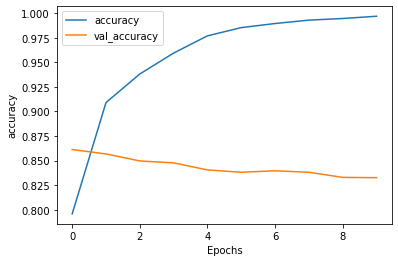

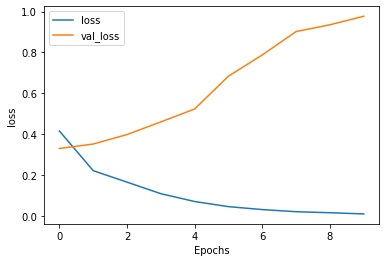

In [20]:
# Plot Utility
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

In [15]:
#Implement the same model using glove embeddings.

# Define path to file containing the embeddings
GLOVE_FILE = './Projects/NLP/data/glove.6B.100d.txt'
VOCAB_SIZE = 40000
# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS = {}

# Read file and fill GLOVE_EMBEDDINGS with its contents
f = open(GLOVE_FILE, encoding = 'utf-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    GLOVE_EMBEDDINGS[word] = coefs

In [18]:
test_word = 'tiger'

test_vector = GLOVE_EMBEDDINGS[test_word]

print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")

print(f"Each word vector has shape: {test_vector.shape}")

Vector representation of word tiger looks like this:

[-0.82157   0.7952    0.80816  -0.09699  -0.11838   0.021151  0.62663
 -0.62621  -0.602    -0.76326  -0.29244   1.0718    1.0264    0.51485
 -0.26717   0.98914  -0.13989  -0.14031   0.068456  0.64535   0.25223
 -0.32911   0.16927   0.38475   0.41674   1.097    -0.66572  -0.64471
 -0.12801  -0.55854  -0.36549   0.079815  0.17361   0.13237   1.0031
 -0.50629  -0.84352   0.8185    0.41386  -0.17179  -0.49508   0.61723
  0.55838   0.36077   0.34123   0.13034  -0.11284   0.4226   -0.67964
 -0.66582  -1.1275    0.16545   0.028074  0.59515   0.40081  -1.5653
 -0.38159   0.16342   0.81675   0.43633  -0.051347  0.68191  -0.66771
  0.94923   0.24136   0.64997   0.24963   0.41191   0.19212   1.1599
 -0.089726 -0.55557  -0.64921  -0.39078  -0.65487   0.031186  0.073248
  0.45036  -0.83119   1.1082    0.29897  -0.83352   0.20487   0.19633
 -0.12631   0.33189  -0.16336  -0.12867   0.22577   1.0092    0.51273
 -0.30085  -0.012987 -0.087924 -0.4734

In [16]:
# Initialize an empty numpy array with the appropriate size
EMBEDDING_DIM = 100
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for 
# each word exists within GloVe's representations, save it in the EMBEDDINGS_MATRIX array
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

In [17]:
MAXLEN = 120
def create_model(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen, weights=[embeddings_matrix], trainable=False),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.0001),metrics=['accuracy']) 

    return model

model = create_model(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)

# Train the model and save the training history
history = model.fit(training_padded, training_labels, epochs=20, validation_data=(testing_padded, testing_labels))

Epoch 1/20
625/625 [==============================] - 33s 49ms/step - loss: 0.6304 - accuracy: 0.6460 - val_loss: 0.5792 - val_accuracy: 0.7058
Epoch 2/20
625/625 [==============================] - 30s 49ms/step - loss: 0.5341 - accuracy: 0.7388 - val_loss: 0.4975 - val_accuracy: 0.7559
Epoch 3/20
625/625 [==============================] - 30s 48ms/step - loss: 0.4698 - accuracy: 0.7783 - val_loss: 0.4558 - val_accuracy: 0.7874
Epoch 4/20
625/625 [==============================] - 29s 47ms/step - loss: 0.4366 - accuracy: 0.7972 - val_loss: 0.4379 - val_accuracy: 0.7949
Epoch 5/20
625/625 [==============================] - 28s 45ms/step - loss: 0.4165 - accuracy: 0.8090 - val_loss: 0.4277 - val_accuracy: 0.7997
Epoch 6/20
625/625 [==============================] - 29s 46ms/step - loss: 0.4001 - accuracy: 0.8181 - val_loss: 0.4095 - val_accuracy: 0.8082
Epoch 7/20
625/625 [==============================] - 29s 47ms/step - loss: 0.3876 - accuracy: 0.8254 - val_loss: 0.4108 - val_accuracy:

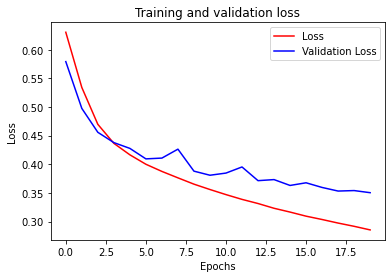

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = [*range(20)]

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()